In [1]:
# libraries
%matplotlib notebook

import pandas as pd
import numpy as np
#import scipy as sc
# import custom_function as cf

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
# from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
# from fbprophet import Prophet

# 1 Data
## 1.1 Extract data
The dataset is from https://www.kaggle.com/boltzmannbrain/nab 
In realKnownCause/ambient_temperature_system_failure.csv

In [15]:
df = pd.read_csv("realKnownCause/realKnownCause/owndata.csv")

## 1.2 Understand data

In [4]:
print(df.head())

       Time   CPU
0  19:18:41  32.0
1  19:18:43  27.7
2  19:18:44  37.2
3  19:18:45  47.9
4  19:18:46  31.2


In [16]:
print(df.shape)

(2656, 2)


In [18]:
# check the temperature mean
print(df['CPU'].mean())
print(df.shape)

31.701242469879492
(2656, 2)


<IPython.core.display.Javascript object>


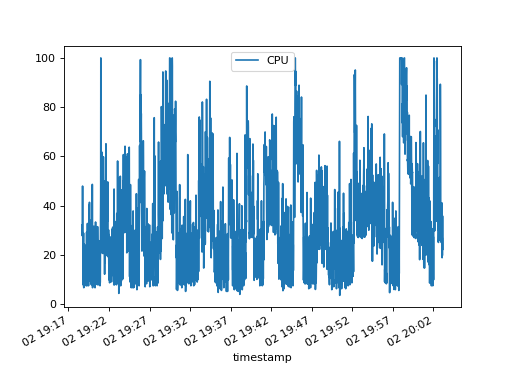

In [19]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['Time'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
# df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='CPU')

In [20]:
# check the timestamp format and frequence 
print(df['timestamp'].head(10))

0   2020-07-02 19:18:41
1   2020-07-02 19:18:43
2   2020-07-02 19:18:44
3   2020-07-02 19:18:45
4   2020-07-02 19:18:46
5   2020-07-02 19:18:47
6   2020-07-02 19:18:48
7   2020-07-02 19:18:49
8   2020-07-02 19:18:50
9   2020-07-02 19:18:51
Name: timestamp, dtype: datetime64[ns]


## 1.3 Feature engineering
Extracting some useful features

In [27]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
# df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
# df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# # time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
df['time_str'] = df['timestamp'].astype(str)

In [22]:
# Take useful feature and standardize them 
data = df[['CPU']]#, 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]

# for c in ['hours', 'daylight', 'DayOfTheWeek', 'WeekDay']:
# #     print(c)
#     print(f"{c} unique values :{data[c].unique()}")
print(data.shape)
data.head()

(2656, 1)


,CPU
0,32.0
1,27.7
2,37.2
3,47.9
4,31.2


In [36]:
from sklearn.neighbors import LocalOutlierFactor

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  LocalOutlierFactor(n_neighbors=50, novelty=True)
data = pd.DataFrame(np_scaled)

test_items = 2374 ## last how many items

model.fit(data[:data.shape[0]-test_items])
# add the data to the main  


full_span = pd.concat([pd.Series([0 for _ in range(data.shape[0]-test_items)]), pd.Series(model.predict(data[data.shape[0]-test_items: data.shape[0]]))], ignore_index=True)
print(data.shape)
print(full_span.shape)
df['anomaly26'] = full_span
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

(2656, 1)
(2656,)
0.0    1666
1.0     708
Name: anomaly26, dtype: int64


<IPython.core.display.Javascript object>


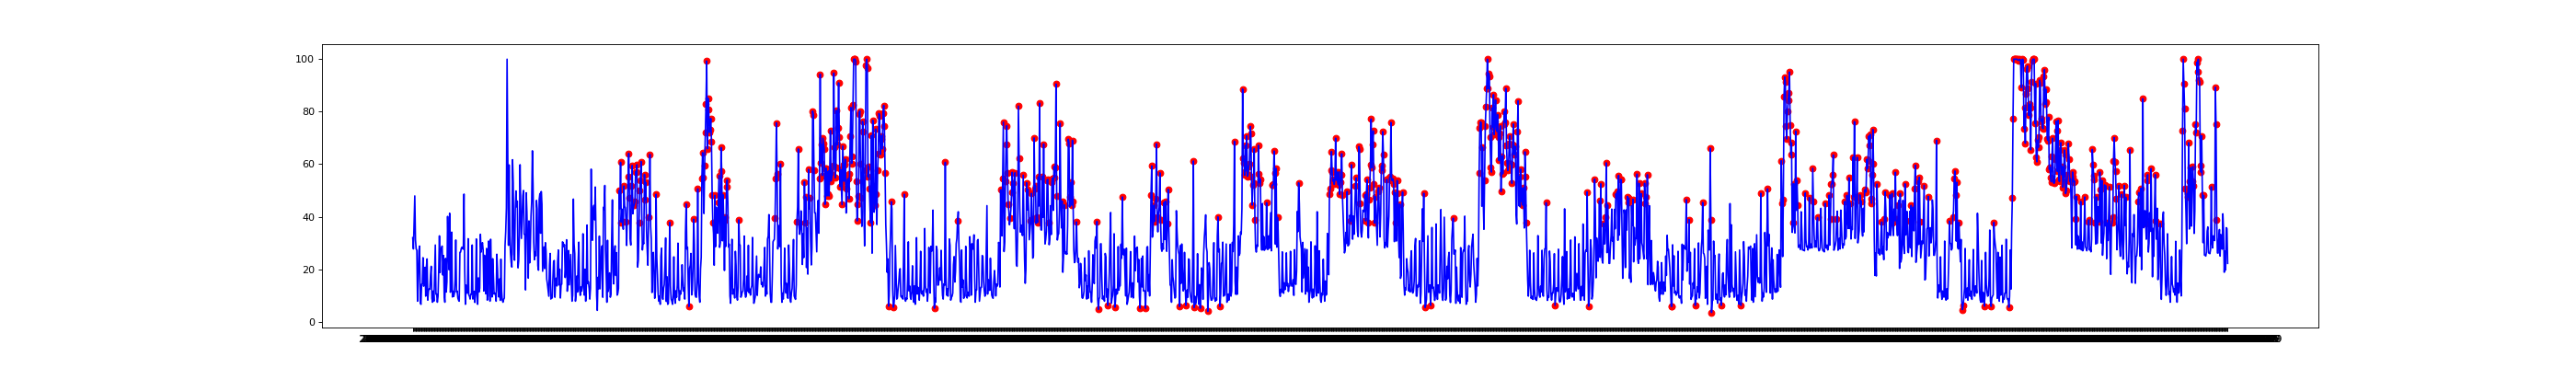

In [44]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(35, 5))


a = df.loc[df['anomaly26'] == 1, ['time_str', 'CPU']] #anomaly



ax.plot(df['time_str'], df['CPU'], color='blue')
ax.scatter(a['time_str'],a['CPU'], color='red')
ax.set_xticks(df.index)

plt.show()
plt.savefig("plot.png")